In [1]:
import os
import pathlib

import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras import models
from IPython import display
from pydub import AudioSegment
from pydub.silence import detect_nonsilent
import os
import librosa
import matplotlib.pyplot as plt

import pyaudio
import wave
import sounddevice as sd
import soundfile as sf


# Set the seed value for experiment reproducibility.
seed = 10
tf.random.set_seed(seed)
np.random.seed(seed)

D:\Learn_Py\DataSci\venv\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [9]:
def remove_sil(path_in, path_out, format="wav"):
    sound = AudioSegment.from_file(path_in, format=format)
    non_sil_times = detect_nonsilent(sound, min_silence_len=50, silence_thresh=sound.dBFS * 1.5)
    if len(non_sil_times) > 0:
        non_sil_times_concat = [non_sil_times[0]]
        if len(non_sil_times) > 1:
            for t in non_sil_times[1:]:
                if t[0] - non_sil_times_concat[-1][-1] < 50:
                    non_sil_times_concat[-1][-1] = t[1]
                else:
                    non_sil_times_concat.append(t)
        non_sil_times = [t for t in non_sil_times_concat if t[1] - t[0] > 80]
        sound[non_sil_times[0][0]: non_sil_times[-1][1]].export(path_out, format='wav')

In [10]:
DATASET_PATH = 'data_train'
data_dir = pathlib.Path(DATASET_PATH)
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
print('Commands:', commands)

Commands: ['batden' 'batdieuhoa' 'batquat' 'dongcua' 'giamtocdoquat' 'mocua'
 'tangtocdoquat' 'tatden' 'tatdieuhoa' 'tatquat']


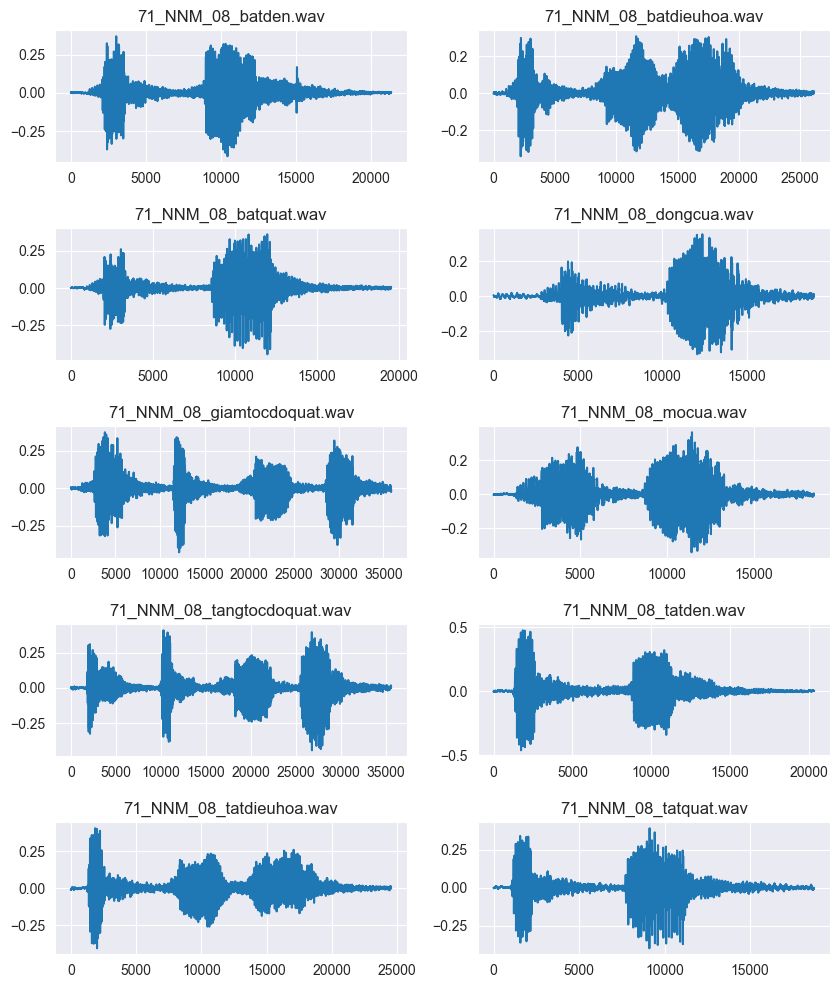

In [11]:
data_folder = 'data_show'

# Get the list of WAV files in the data folder
wav_files = [file for file in os.listdir(data_folder) if file.endswith('.wav')]

# Set the number of rows and columns for subplots
rows = 5
cols = 2

# Create the subplots with specified figsize
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

# Iterate over the WAV files
for i, wav_file in enumerate(wav_files[:rows * cols]):
    # Get the path to the WAV file
    wav_path = os.path.join(data_folder, wav_file)

    # Load the audio file
    audio, sr = librosa.load(wav_path)

    # Plot the waveform
    ax = axes[i // cols][i % cols]
    ax.plot(audio)
    ax.set_title(wav_file)

# Adjust the spacing between subplots
fig.subplots_adjust(hspace=0.5)

plt.savefig('wave_form_show')
# Show the plot
plt.show()

In [12]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 600
Number of examples per label: 60
Example file tensor: tf.Tensor(b'data_train\\batden\\58_NTH_01_batden.wav', shape=(), dtype=string)


In [13]:
data_test = pathlib.Path('data_test')
data_val = pathlib.Path('data_val')
filenames_test = tf.io.gfile.glob(str(data_test) + '/*/*')
filenames_test = tf.random.shuffle(filenames_test)
filenames_val = tf.io.gfile.glob(str(data_val) + '/*/*')
filenames_val = tf.random.shuffle(filenames_val)

In [14]:
train_files = filenames
val_files = filenames_val
test_files = filenames_test

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 600
Validation set size 200
Test set size 200


In [15]:
test_file = tf.io.read_file('data/batdieuhoa/42_LVA_01_batdieuhoa.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([21346, 1])

In [16]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)

In [17]:
def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-2]

In [18]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

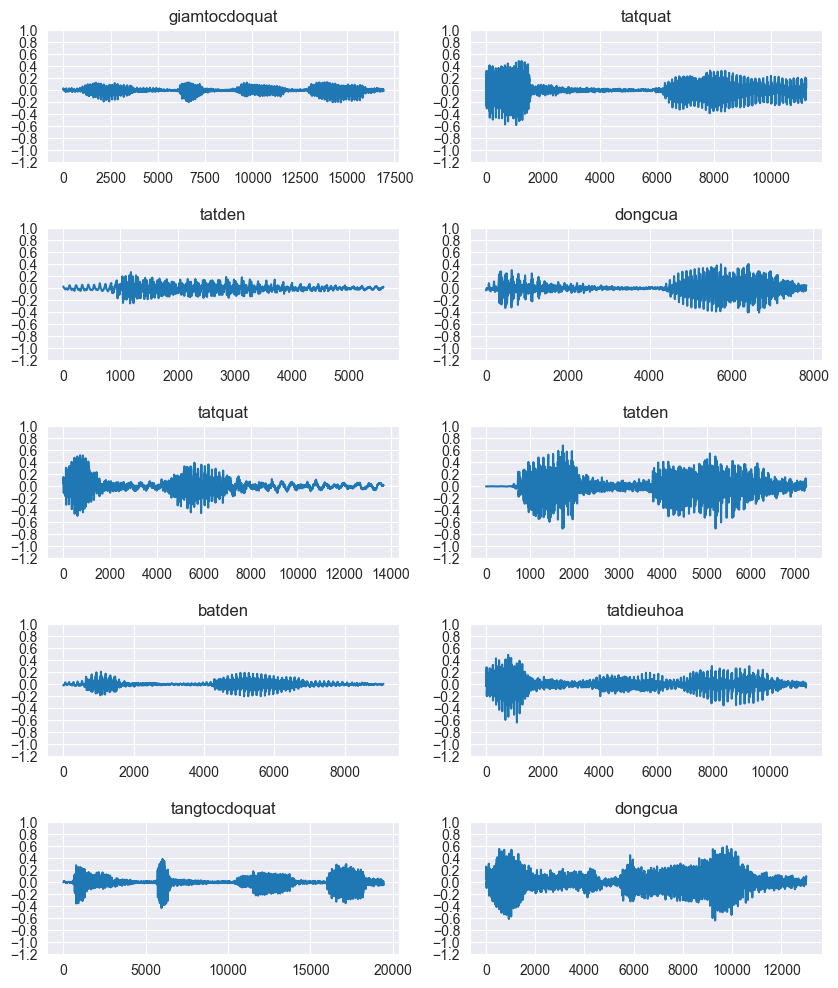

In [716]:
rows = 5
cols = 2
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

fig.subplots_adjust(hspace=0.5)
plt.show()


In [20]:
def get_spectrogram(waveform):
  input_len = 32000
  waveform = waveform[:input_len]
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=256, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  # Resize the spectrogram to a fixed size
  spectrogram = tf.image.resize(spectrogram, size=(256, 256))
  return spectrogram

In [718]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: giamtocdoquat
Waveform shape: (16928,)
Spectrogram shape: (256, 256, 1)
Audio playback


In [21]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

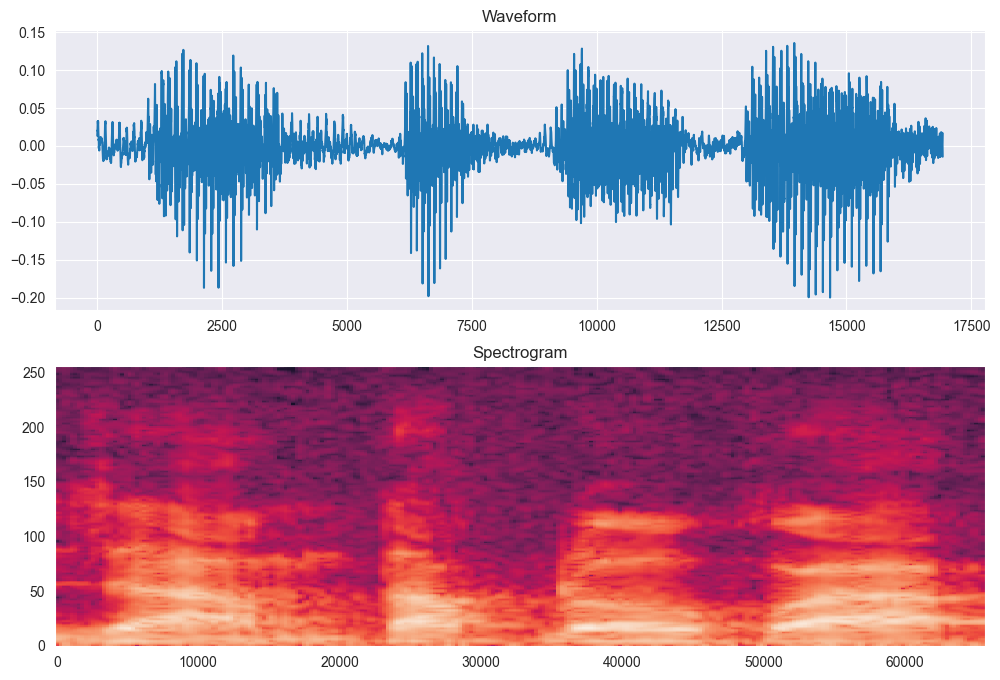

In [720]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [26]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [27]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

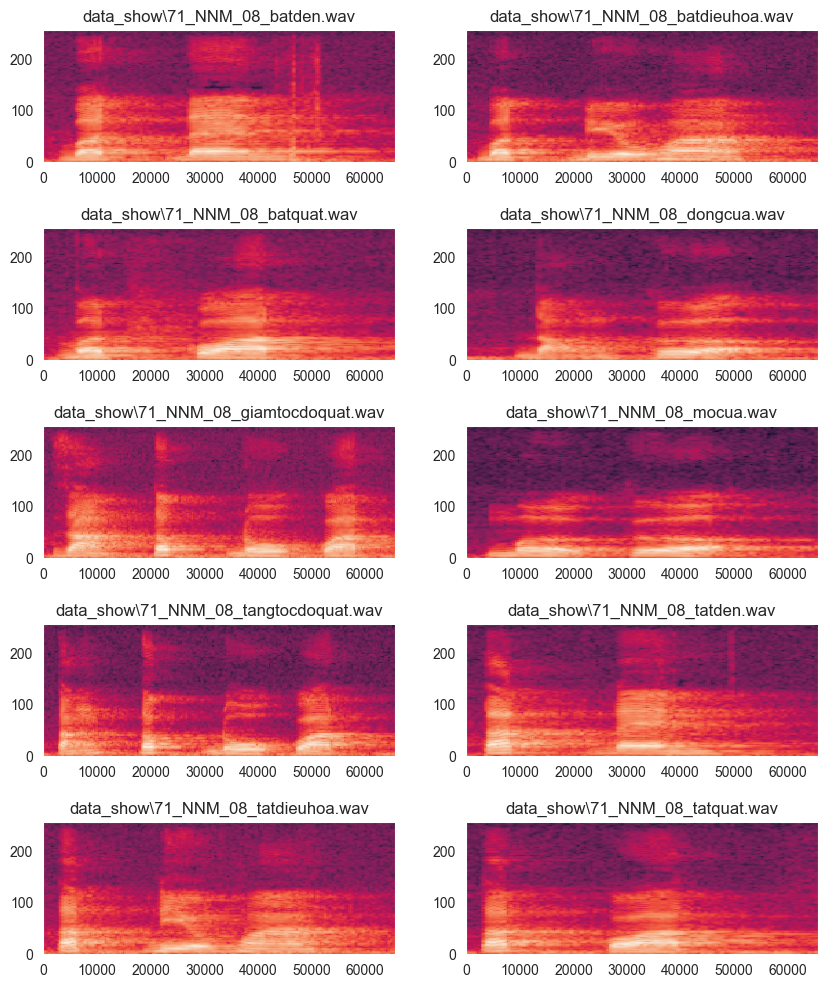

In [33]:
data_folder = 'data_show'
audio_files = [os.path.join(data_folder, file) for file in os.listdir(data_folder) if file.endswith('.wav')]
rows = 5
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, audio_file in enumerate(audio_files[:rows * cols]):
    waveform, label = get_waveform_and_label(audio_file)
    spectrogram = get_spectrogram(waveform)

    ax = axes[i // cols][i % cols]
    plot_spectrogram(spectrogram, ax)
    ax.set_title(audio_file)

fig.subplots_adjust(hspace=0.5)
plt.savefig('spectrogram_show.png')
plt.show()


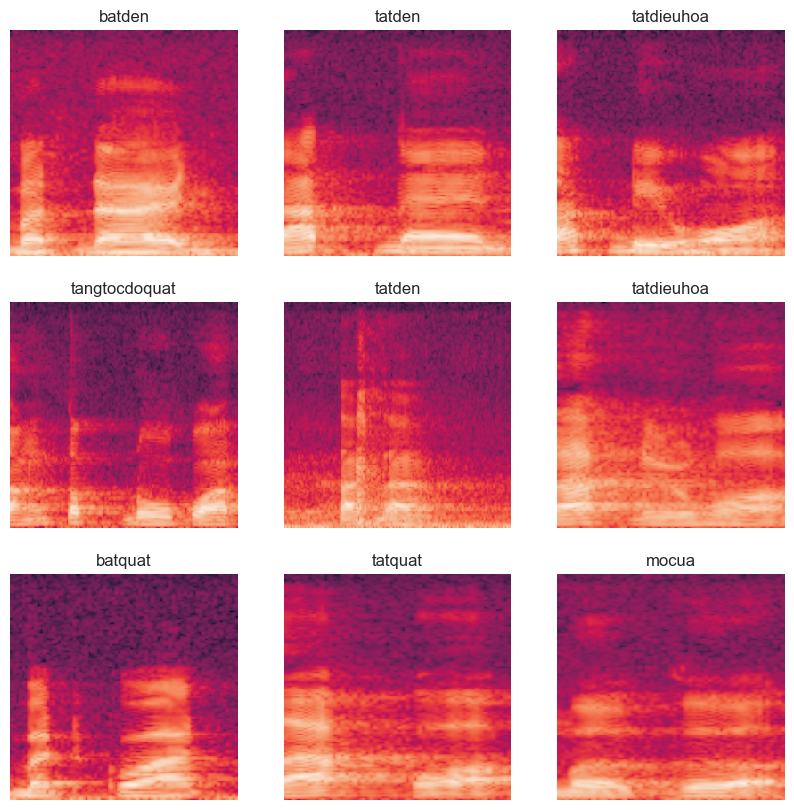

In [32]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

In [724]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [725]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [726]:
batch_size = 35
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [727]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [728]:
from keras.utils import plot_model
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()
# plot_model(model, to_file='model_graph.png', show_shapes=True)

Input shape: (256, 256, 1)
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_20 (Resizing)      (None, 32, 32, 1)         0         
                                                                 
 normalization_20 (Normaliza  (None, 32, 32, 1)        3         
 tion)                                                           
                                                                 
 conv2d_40 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 conv2d_41 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 dropout_40 (Dropout)     

In [729]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


In [730]:
EPOCHS = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/15
18/18 [==============================] - 2s 74ms/step - loss: 2.0641 - accuracy: 0.2683 - val_loss: 1.4160 - val_accuracy: 0.6300
Epoch 2/15
18/18 [==============================] - 1s 44ms/step - loss: 1.3968 - accuracy: 0.5117 - val_loss: 0.9437 - val_accuracy: 0.7000
Epoch 3/15
18/18 [==============================] - 1s 43ms/step - loss: 1.0259 - accuracy: 0.6567 - val_loss: 0.7900 - val_accuracy: 0.7550
Epoch 4/15
18/18 [==============================] - 1s 43ms/step - loss: 0.9267 - accuracy: 0.6617 - val_loss: 0.7318 - val_accuracy: 0.8200
Epoch 5/15
18/18 [==============================] - 1s 44ms/step - loss: 0.7278 - accuracy: 0.7467 - val_loss: 0.7128 - val_accuracy: 0.8200
Epoch 6/15
18/18 [==============================] - 1s 43ms/step - loss: 0.5832 - accuracy: 0.7983 - val_loss: 0.7643 - val_accuracy: 0.8250
Epoch 7/15
18/18 [==============================] - 1s 46ms/step - loss: 0.4941 - accuracy: 0.8250 - val_loss: 0.7062 - val_accuracy: 0.8750
Epoch 8/15
18

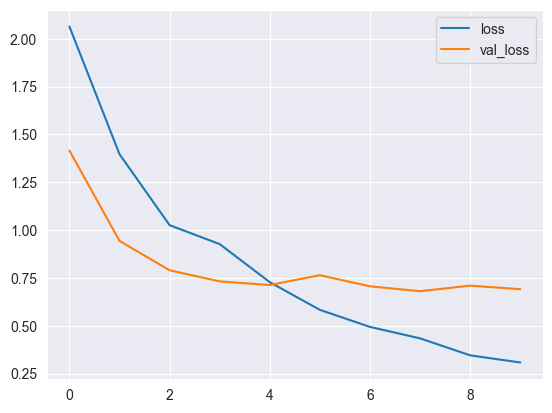

In [731]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [733]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

7/7 [==============================] - 0s 10ms/step
Test set accuracy: 94%


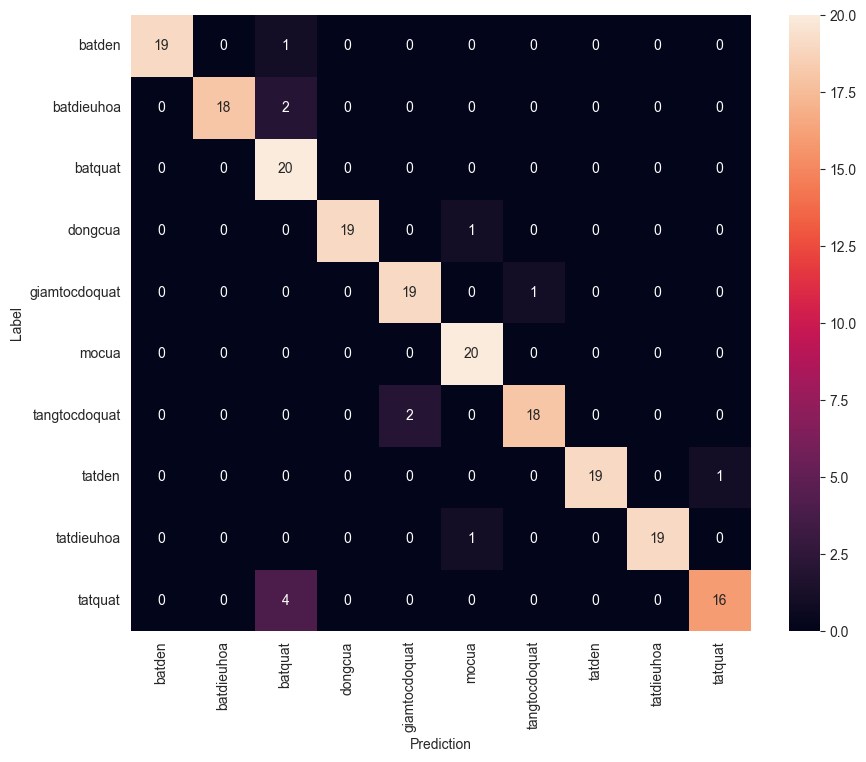

In [734]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.savefig('image')
plt.show()

In [739]:
model.save('CNN_final2.h5')

In [835]:
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 16000
CHUNK = 512
RECORD_SECONDS = 2
WAVE_OUTPUT_FILENAME = "new_audio.wav"

p = pyaudio.PyAudio()

# Tìm kiếm thiết bị âm thanh
for i in range(p.get_device_count()):
    dev = p.get_device_info_by_index(i)
    if 'Microphone' in dev['name']:
        device_name = dev['name']
        break
print('Bắt đầu ghi âm...')
# Khởi tạo stream
stream = p.open(format=FORMAT, channels=CHANNELS, rate=RATE, input=True, input_device_index=i, frames_per_buffer=CHUNK)

# Ghi âm
frames = []
for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)

print('Đã ghi âm xong!')

# Dừng stream
stream.stop_stream()
stream.close()
p.terminate()

# Lưu file âm thanh
wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

# remove_silence(WAVE_OUTPUT_FILENAME)
remove_sil("new_audio.wav","audio.wav")

# Đọc file âm thanh đã cắt
new_audio_binary = tf.io.read_file("audio.wav")
new_waveform = decode_audio(new_audio_binary)
new_spectrogram = get_spectrogram(new_waveform)
new_spectrogram = tf.expand_dims(new_spectrogram, axis=0)
predictions = model.predict(new_spectrogram)
print(predictions)


# Chuyển đổi các xác suất thành nhãn
predicted_label_id = np.argmax(predictions[0])
predicted_label = commands[predicted_label_id]

print('Predicted label:', predicted_label)

Bắt đầu ghi âm...
Đã ghi âm xong!
1/1 [==============================] - 0s 18ms/step
[[-2.3370543  1.6972197 -3.3797638 -3.196336   8.050428   1.5028119
   5.4483457 -1.9725503  0.5724152 -6.6172514]]
Predicted label: giamtocdoquat


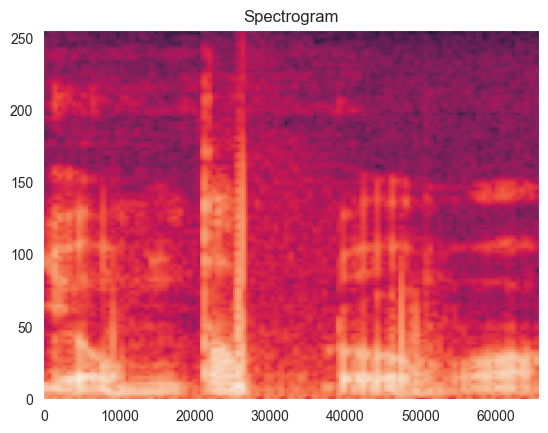

In [836]:
fig, ax = plt.subplots()
plot_spectrogram(new_spectrogram.numpy().reshape(new_spectrogram.shape[1], new_spectrogram.shape[2]), ax)
ax.set(title='Spectrogram')
plt.show()

In [823]:
filename = "new_audio.wav"
data, fs = sf.read(filename, dtype='float32')
sd.play(data, fs)
status = sd.wait()  # đợi cho việc phát âm thanh hoàn tất